In [1]:
import pandas as pd
from torch.utils.data import DataLoader, Dataset
from sklearn.feature_extraction.text import CountVectorizer
import torch
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore") 
from sklearn.metrics import confusion_matrix
import numpy as np

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/4.2/soft_com/Dataset/Assignment3/Dataset_3.csv',encoding='latin1')
df = df.sample(frac=1).reset_index(drop=True)
df.sample(10)

,tweets,sentiment
9654,The world was suffering from the Great Depress...,1
7223,@eoghanquigg you were great at the boyzone con...,0
6776,Just one puff of this type of cannabis 'could ...,1
8992,"Cat Depression Ã¢ÂÂÃÂ Signs, Causes and How...",1
3515,london. . . You look beautiful,0
1825,"August - loftless: lease ends, new rent starts...",0
2057,"@TamboManJoe HEHE hey come to cancun,mexico PL...",0
5799,@therealnuma Awesome me too Got a busy two we...,0
5060,Is soooo Happy cos things have changed .. and ...,0
6024,@mrskimyadawson This is how I found you on her...,0


In [3]:
df.groupby('sentiment').size()

sentiment
0    8000
1    2314
dtype: int64

Text(0.5, 0, 'sentiment')

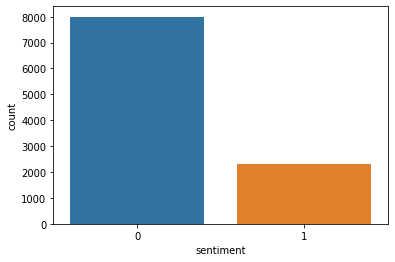

In [ ]:
sns.countplot(df.sentiment)
plt.xlabel('sentiment')

In [5]:
class Sequences(Dataset):
    def __init__(self, data):
        self.vectorizer = CountVectorizer(stop_words='english')
        self.sequences = self.vectorizer.fit_transform(data.tweets.tolist())
        self.labels = data.sentiment.tolist()
        self.token2idx = self.vectorizer.vocabulary_
        self.idx2token = {idx: token for token, idx in self.token2idx.items()}
    
    def __getitem__(self, i):
        return self.sequences[i, :].toarray(), self.labels[i]
    
    def __len__(self):
        return self.sequences.shape[0]

In [6]:
batch_size = 100

In [7]:
dataset = Sequences(df)
train_size = int(len(dataset)*.8);
test_size = int(len(dataset) - train_size);
train_dataset, test_dataset = torch.utils.data.random_split(dataset,[train_size, test_size])
train_loader = DataLoader(train_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [16]:
len(dataset.token2idx)

22212

In [ ]:
input_size = len(dataset.token2idx)
hidden_size = 128
num_classes = 2
num_layers = 3
learning_rate = 0.01
sequence_length = 1
num_epochs = 4

In [ ]:
print(len(train_dataset))
print(len(test_dataset))

8251
2063


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [ ]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(RNN, self).__init__()
        self.D = 2
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(self.D*hidden_size, num_classes)
    
    def forward(self, x):
        # Set initial hidden and cell states 
        h0 = torch.zeros(self.D*self.num_layers, x.size(0), self.hidden_size).to(device) 
        
        # Forward propagate LSTM
        out, _ = self.rnn(x, h0) 
        h0 = torch.zeros(self.D*self.num_layers, out.size(0), self.hidden_size).to(device) 
        
        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])
        return out

In [ ]:
model = RNN(input_size, hidden_size, num_layers, num_classes).to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
# Train the model
y_pred = []
y_test = []
iter = []
losses = []
itr = 0
total_step = len(train_loader)
for epoch in range(num_epochs):
    for i, (tweets, labels) in enumerate(train_loader):
        tweets = tweets.reshape(-1, sequence_length, input_size).to(device)
        labels = labels.to(device)
        tweets = torch.tensor(tweets, dtype = torch.float)
        # Forward pass
        outputs = model(tweets)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        itr = itr + 1
        if (i+1) % 20 == 0:
            iter.append(itr)
            losses.append(loss.item())
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
        
# Test the model
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for tweets, labels in test_loader:
        tweets = tweets.reshape(-1, sequence_length, input_size).to(device)
        labels = labels.to(device)
        tweets = torch.tensor(tweets, dtype = torch.float)
        outputs = model(tweets)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        y_pred.extend(predicted)
        y_test.extend(labels)

    print('Test Accuracy of the model on the 10000 test tweets: {} %'.format(100 * correct / total)) 

# Save the model checkpoint
torch.save(model.state_dict(), 'model.ckpt')

Epoch [1/4], Step [20/83], Loss: 0.0848
Epoch [1/4], Step [40/83], Loss: 0.0792
Epoch [1/4], Step [60/83], Loss: 0.0332
Epoch [1/4], Step [80/83], Loss: 0.0348
Epoch [2/4], Step [20/83], Loss: 0.0228
Epoch [2/4], Step [40/83], Loss: 0.0000
Epoch [2/4], Step [60/83], Loss: 0.0077
Epoch [2/4], Step [80/83], Loss: 0.0307
Epoch [3/4], Step [20/83], Loss: 0.0215
Epoch [3/4], Step [40/83], Loss: 0.0016
Epoch [3/4], Step [60/83], Loss: 0.0006
Epoch [3/4], Step [80/83], Loss: 0.0071
Epoch [4/4], Step [20/83], Loss: 0.0114
Epoch [4/4], Step [40/83], Loss: 0.0006
Epoch [4/4], Step [60/83], Loss: 0.0000
Epoch [4/4], Step [80/83], Loss: 0.0001
Test Accuracy of the model on the 10000 test tweets: 98.78817256422685 %


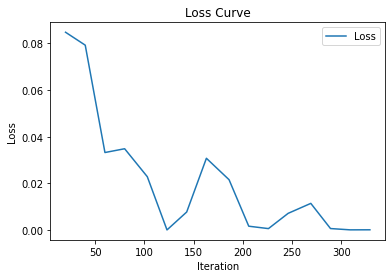

In [ ]:
plt.plot(iter, losses, label='Loss')
plt.title('Loss Curve')
plt.ylabel('Loss')
plt.xlabel('Iteration')
plt.legend()

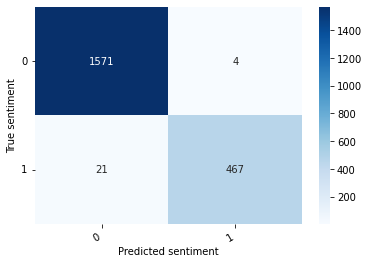

In [ ]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=[0,1], columns=[0,1])
show_confusion_matrix(df_cm)

In [ ]:
tp = 0
tn = 0
fp = 0
fn = 0
for i in range(len(y_test)):
  tn += ((y_pred[i] == 0) &  (y_test[i] == 0)).float()
  tp += ((y_pred[i] == 1) &  (y_test[i] == 1)).float()
  fn += ((y_pred[i] == 0) &  (y_test[i] == 1)).float()
  fp += ((y_pred[i] == 1) &  (y_test[i] == 0)).float()

print(tn, ' ', fn, ' ', fp, ' ', tp)

tensor(1571.)   tensor(21.)   tensor(4.)   tensor(467.)


In [ ]:
precision = tp/(tp+fp)
recall = tp/(tp+fn)
f1_score = 2* ((precision*recall)/(precision+recall))

In [ ]:
print('Precision: ', precision.item(), 'Recall: ', recall.item(),  'F1_score: ', f1_score.item())

Precision:  0.9915074110031128 Recall:  0.9569672346115112 F1_score:  0.9739311337471008


In [ ]:
def table(l1, columns):
  plt.rcParams["figure.figsize"] = [10, 2]
  plt.rcParams["figure.autolayout"] = True
  
  fig, axs = plt.subplots(1, 1)
  data = np.column_stack(l1)
  axs.axis('tight')
  axs.axis('off')
  the_table = axs.table(cellText=data, colLabels=columns, loc='center', cellLoc = 'center')
  the_table.auto_set_font_size(False)
  the_table.set_fontsize(18)
  the_table.scale(1.5, 1.5)
  plt.show()

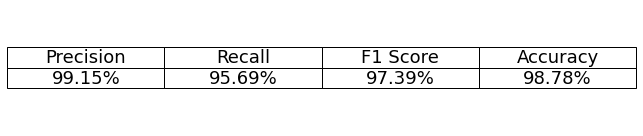

In [ ]:
table(['99.15%','95.69%','97.39%','98.78%'],['Precision', 'Recall', 'F1 Score', 'Accuracy'])